# Логичтическая регрессия, метод опорных векторов, one-hot кодирование

### О задании

В этом задании вы изучите методы работы с категориальными переменными

In [62]:
%pylab inline
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy import sparse


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


__Задание 1.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.

**(2 балла)**


Загрузим данные с конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [63]:
data = pd.read_csv('/content/train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [64]:
from sklearn.model_selection import train_test_split
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)
data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Обучите логистическую регрессию с удобными для вас параметрами, примените регуляризацию, найдтие оптимум. Сделайте предсказание на тестовой части выборки. Замерьте качество.

In [66]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', random_state=83).fit(X_train, y_train)

__Выводы__ в свободной форме:

__Задание 2.__ Изучение влияния регуляризатора на процесс обучения

__(2 балла)__

Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

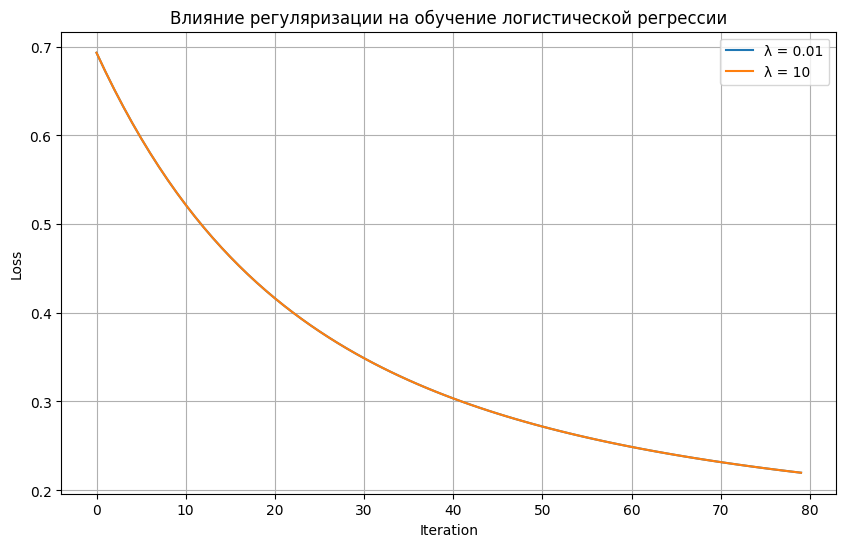

In [67]:
df = pd.read_csv('/content/train.csv')
y = df["target"].values.reshape(-1, 1)
X = df.drop(columns=["id", "target"]).values
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
X = np.hstack([np.ones((X.shape[0], 1)), X])
def train_logreg(X, y, lr, lam, iters):
    n, d = X.shape
    w = np.zeros((d, 1))
    losses = []
    for t in range(iters):
        z = X @ w
        p = 1 / (1 + np.exp(-z))
        loss = (-np.mean(y * np.log(p + 1e-9) + (1 - y) * np.log(1 - p + 1e-9))
            + (lam / (2 * n)) * np.sum(w[1:] ** 2)   # L2 штраф без w0
        )
        losses.append(loss)
        grad = X.T @ (p - y) / n
        grad[1:] += (lam / n) * w[1:]
        w -= lr * grad
    return w, losses

w1, loss1 = train_logreg(X, y, lr=0.1, lam=0.01, iters=80)
w2, loss2 = train_logreg(X, y, lr=0.1, lam=10, iters=80)
plt.figure(figsize=(10, 6))
plt.plot(loss1, label="λ = 0.01")
plt.plot(loss2, label="λ = 10")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Влияние регуляризации на обучение логистической регрессии")
plt.legend()
plt.grid(True)
plt.show()


__Выводы:__

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.

__(3 балла)__

In [68]:
y = df["target"].values
X = df.drop(columns=["id", "target"])
cat_features = [col for col in X.columns if "_cat" in col]
num_features = [col for col in X.columns if col not in cat_features]
X_cat = X[cat_features]
X_num = X[num_features]
ohe = OneHotEncoder(handle_unknown="ignore")
X_cat_ohe = ohe.fit_transform(X_cat)
X_full = sparse.hstack([sparse.csr_matrix(X_num.values), X_cat_ohe])
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)
clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, preds)
print(auc)

0.6326543905803812


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

__(2 балла)__

__Вывод:__

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков).

__Задание 3.__ Реализуйте корректное вычисление счётчиков двумя из трех вышеперчисленных способов, сравните. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(3 балла)__

In [69]:
# Your code here
# ...

__Вывод:__